<a href="https://colab.research.google.com/github/niku2712/Topic-modelling-using-GSDMM-LDA-and-LSA/blob/main/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd

import sys

import gensim, spacy
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
import re


from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [ ]:
#Loading dataset
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/tripadvisor_hotel_reviews.csv',encoding = 'utf-8')
print(df.shape)  
df.head()

(20491, 2)


Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

In [ ]:
df['length'] = df.Review.apply(lambda row: len(row.split()))
print('Mean length: ', df['length'].mean())

Mean length:  104.37582353228247


In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-5-5a61a3f7993a>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['length'])


<Axes: xlabel='length', ylabel='Density'>

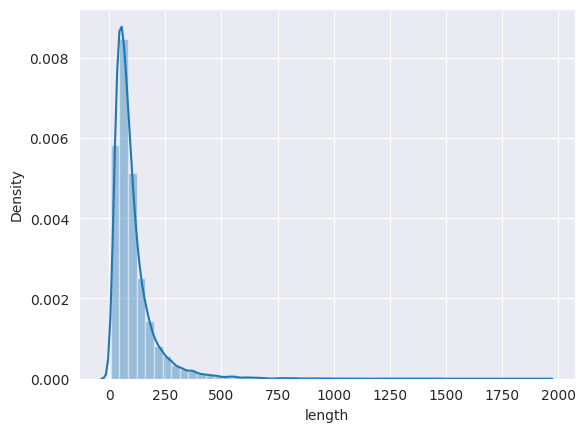

In [ ]:
import seaborn as sns
sns.set_style(style="darkgrid")

sns.distplot(df['length'])

In [ ]:
df['review_list'] = df.Review.values.tolist()

# remove characters
df['review_list'] = [re.sub('\s+', ' ', sent) for sent in df['review_list']]
df['review_list'] = [re.sub("\'", "", sent) for sent in df['review_list']]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [ ]:
# create bigram and trigram
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

In [ ]:
tokens_reviews = list(sent_to_words(df['review_list']))

In [ ]:
tokens_reviews = make_n_grams(tokens_reviews)

In [ ]:
pip install git+https://github.com/rwalk/gsdmm.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-j0t5uu4n
  Running command git clone --filter=blob:none --quiet https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-j0t5uu4n
  Resolved https://github.com/rwalk/gsdmm.git to commit 4ad1b6b6976743681ee4976b4573463d359214ee
  Preparing metadata (setup.py) ... done
  Created wheel for gsdmm: filename=gsdmm-0.1-py3-none-any.whl size=4603 sha256=458678e08807e4ca2f8306c9a1c3df41c9e3c2d44eb517ff60ecca98bae5d6d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-oq8op0kf/wheels/81/2c/23/3ff788bcc6063bf30116ad1a06e75d3ba9aad3f7bc4aba765b
Successfully built gsdmm


In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# I use gensim stop-words and add me own stop-words, based on texts
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(['also', 'meanwhile','however', 'time', 
                                                                                                                           'hour', 'soon', 'day', 'book',
                                                                                                                           'there', 'hotel', 'room', 'leave',
                                                                                                                           'arrive',
                                                                                                                           'place', 'stay', 'staff', 'location',
                                                                                                                          'service', 'come', 'check',
                                                                                                                          'ask', 'lot', 'thing', 
                                                                                                                          'soooo', 'add', 'rarely',
                                                                                                                          'use', 'look', 'minute',
                                                                                                                          'bring', 'need', 'world',
                                                                                                                          'think', 'value', 'include']))] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
! python -m spacy download en_core_web_sm

2023-04-12 21:23:42.806576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 43.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# do lemmatization keeping only noun, vb, adv
# because adj is not informative for reviews topic modeling
reviews_lemmatized = lemmatization(tokens_reviews, allowed_postags=['NOUN', 'VERB', 'ADV'])

# remove stop words after lemmatization
reviews_lemmatized = remove_stopwords(reviews_lemmatized)

In [ ]:
reviews_lemmatized

[['parking',
  'deal',
  'anniversary',
  'evening',
  'advice',
  'review',
  'valet_parking',
  'non_existent',
  'view',
  'size',
  'bed',
  'wake',
  'neck',
  'pillow',
  'hear',
  'music',
  'night',
  'morning',
  'bang',
  'door',
  'opening_close',
  'hear',
  'people',
  'talk',
  'hallway',
  'maybe',
  'neighbor',
  'goldfish',
  'touch',
  'advantage',
  'shop',
  'experience',
  'pay',
  'parking',
  'night'],
 ['charge',
  'diamond_member',
  'decide',
  'chain',
  'shoot',
  'anniversary',
  'seattle',
  'start',
  'suite',
  'pay',
  'website',
  'description',
  'suite',
  'bedroom',
  'bathroom',
  'print',
  'reservation',
  'desk',
  'tv',
  'couch',
  'ect',
  'desk_clerk',
  'tell',
  'suite',
  'breakfast',
  'kid',
  'embassy',
  'suit',
  'sit',
  'bathroom',
  'bedroom',
  'offer',
  'false_advertise',
  'send',
  'prefer',
  'guest',
  'website',
  'email',
  'failure',
  'provide',
  'suite',
  'website',
  'reservation',
  'description',
  'furnish',
  'c

# **Creating GSDMM model**


In [ ]:
np.random.seed(0)

In [ ]:
from gsdmm import MovieGroupProcess
mgp = MovieGroupProcess(K=6, alpha=0.01, beta=0.01, n_iters=10)

vocab = set(x for review in reviews_lemmatized for x in review)
n_terms = len(vocab)
model = mgp.fit(reviews_lemmatized, n_terms)

In stage 0: transferred 15769 clusters with 6 clusters populated
In stage 1: transferred 8491 clusters with 6 clusters populated
In stage 2: transferred 5316 clusters with 6 clusters populated
In stage 3: transferred 4247 clusters with 6 clusters populated
In stage 4: transferred 3840 clusters with 6 clusters populated
In stage 5: transferred 3496 clusters with 6 clusters populated
In stage 6: transferred 3232 clusters with 6 clusters populated
In stage 7: transferred 2936 clusters with 6 clusters populated
In stage 8: transferred 2681 clusters with 6 clusters populated
In stage 9: transferred 2520 clusters with 6 clusters populated


In [ ]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [ ]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [1061 2697 3607 3906 2558 6662]

Most important clusters (by number of docs inside): [5 3 2 1 4 0]

Cluster 5 : [('resort', 8621), ('beach', 8132), ('food', 7404), ('pool', 6690), ('night', 5958), ('restaurant', 5711), ('people', 5045), ('want', 4048), ('drink', 3626), ('bar', 3462)]

Cluster 3 : [('breakfast', 2680), ('night', 2013), ('walk', 1960), ('restaurant', 1339), ('recommend', 1103), ('bathroom', 1061), ('city', 1000), ('area', 966), ('bed', 887), ('return', 872)]

Cluster 2 : [('night', 2212), ('breakfast', 1450), ('bed', 1386), ('walk', 1312), ('restaurant', 1213), ('view', 1119), ('area', 1030), ('price', 949), ('bathroom', 877), ('love', 850)]

Cluster 1 : [('night', 1859), ('breakfast', 1366), ('bed', 1232), ('bathroom', 1122), ('walk', 892), ('view', 803), ('floor', 790), ('price', 716), ('area', 698), ('restaurant', 628)]

Cluster 4 : [('night', 1506), ('breakfast', 1329), ('walk', 1183), ('view', 1018), ('restaurant', 976), ('bed', 940),

In [ ]:
# I don`t rename the clusters

topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [ ]:
def create_topics_dataframe(data_text=df.Review,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Rating', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        result.at[i, 'Rating'] = df.Rating[i]
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(reviews_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [ ]:
result = create_topics_dataframe(data_text=df.Review, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized)
result.head(5)

Text   Topic Rating  \
0  nice hotel expensive parking got good deal sta...  type 6      4   
1  ok nothing special charge diamond member hilto...   Other      2   
2  nice rooms not 4* experience hotel monaco seat...  type 1      3   
3  unique, great stay, wonderful time hotel monac...  type 5      5   
4  great stay great stay, went seahawk game aweso...   Other      5   

                                          Lemma-text  
0  [parking, deal, anniversary, evening, advice, ...  
1  [charge, diamond_member, decide, chain, shoot,...  
2  [experience, level, positive, bathroom, bed, h...  
3  [stroll, downtown, shopping, area, sign, anima...  
4  [game, downfall, view, building, complain, web...

In [ ]:
import plotly.express as px

fig = px.pie(result, names='Topic',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

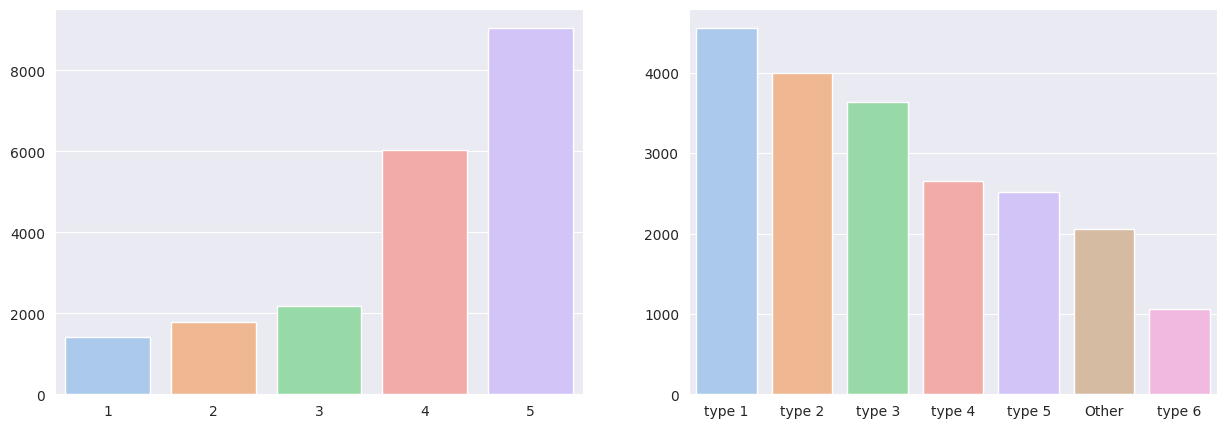

In [ ]:
import matplotlib.pyplot as plt

rating_counts = result.Rating.value_counts()
types_counts = result.Topic.value_counts()
fig, ax = plt.subplots(1, 2, figsize=(15,5))
rating = sns.barplot(x = rating_counts.index, y = rating_counts.values, palette="pastel", ax=ax[0])
types = sns.barplot(x = types_counts.index, y = types_counts.values, palette="pastel", ax=ax[1])

In [ ]:
fig = px.sunburst(result, path=['Topic', 'Rating'], title='Topics and ratings', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [ ]:
result['len'] = result.Text.apply(lambda row: len(row.split()))
result.head()

Text   Topic Rating  \
0  nice hotel expensive parking got good deal sta...  type 6      4   
1  ok nothing special charge diamond member hilto...   Other      2   
2  nice rooms not 4* experience hotel monaco seat...  type 1      3   
3  unique, great stay, wonderful time hotel monac...  type 5      5   
4  great stay great stay, went seahawk game aweso...   Other      5   

                                          Lemma-text  len  
0  [parking, deal, anniversary, evening, advice, ...   87  
1  [charge, diamond_member, decide, chain, shoot,...  250  
2  [experience, level, positive, bathroom, bed, h...  217  
3  [stroll, downtown, shopping, area, sign, anima...   89  
4  [game, downfall, view, building, complain, web...  191

<ipython-input-28-4abb20d0ffd8>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-28-4abb20d0ffd8>:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



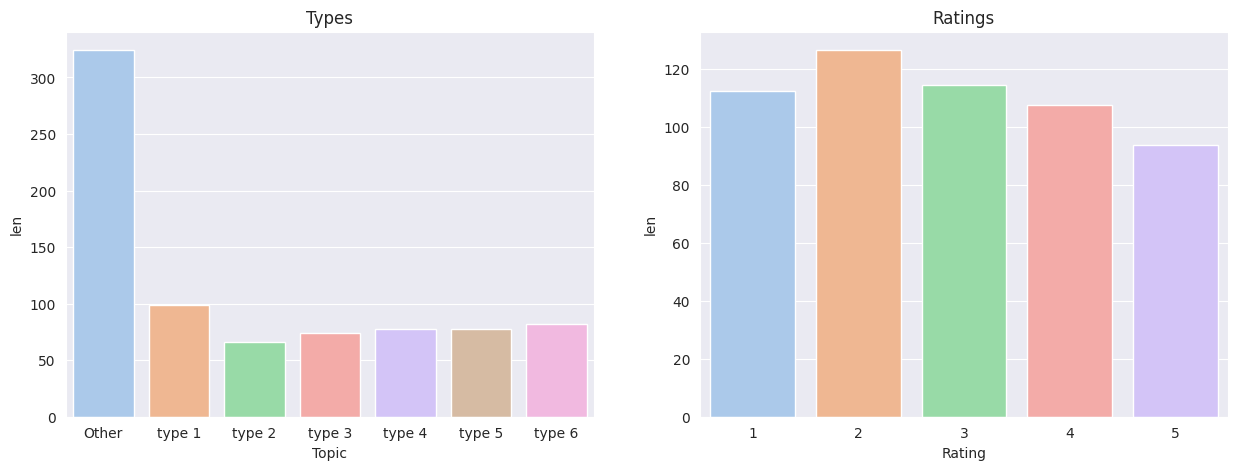

In [ ]:
types_len = result.groupby(by=['Topic']).mean()
rating_len = result.groupby(by=['Rating']).mean()

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('Types')
ax[1].set_title('Ratings')
types = sns.barplot(x = types_len.index, y = types_len['len'], palette="pastel",  ax=ax[0])
rating = sns.barplot(x = rating_len.index, y = rating_len['len'], palette="pastel", ax=ax[1])

In [ ]:
result.Rating = pd.to_numeric(result.Rating)

<ipython-input-30-f3e42babffce>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



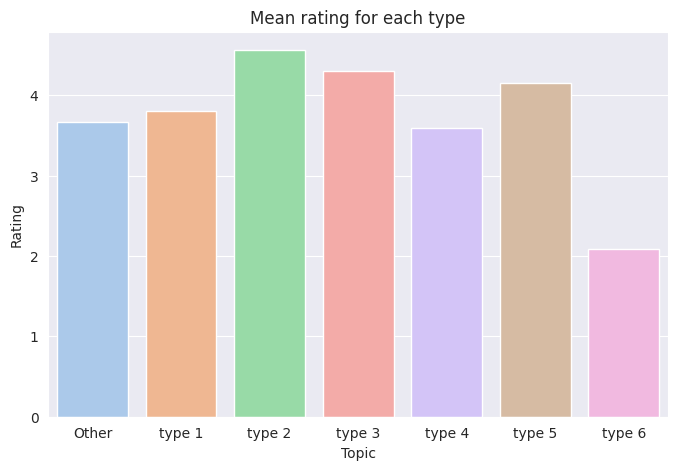

In [ ]:
types_rating = result.drop('len', axis='columns').groupby(by=['Topic']).mean()

fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean rating for each type')
types = sns.barplot(x = types_rating.index, y = types_rating.Rating, palette="pastel")

In [ ]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))

In [ ]:
result = result.drop('Lemma-text', axis=1)

In [ ]:
from wordcloud import WordCloud 

In [ ]:
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

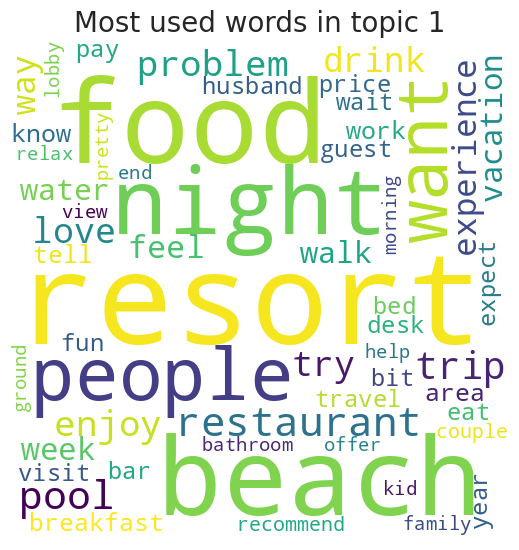

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 1'], title="Most used words in topic 1")

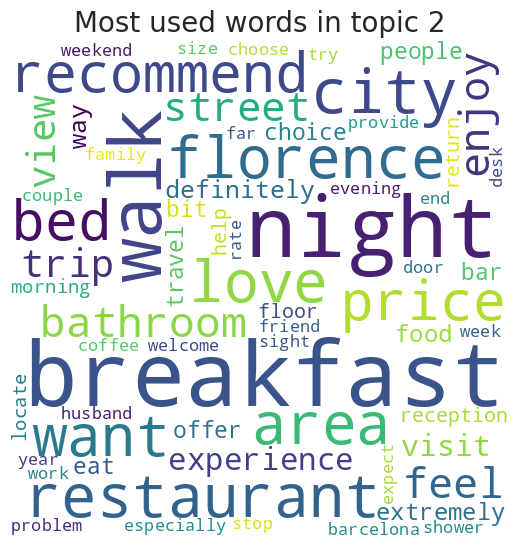

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 2'], title="Most used words in topic 2")

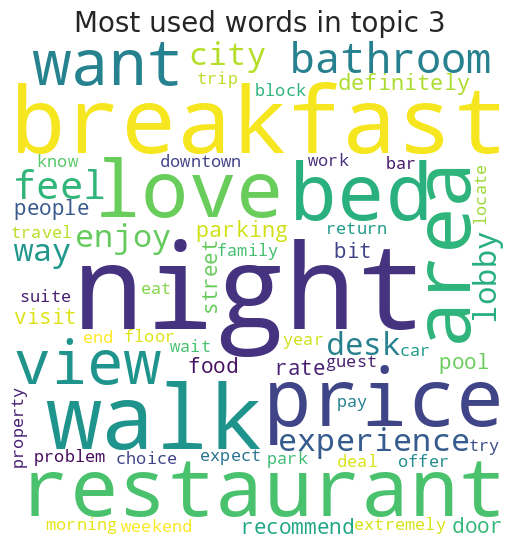

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 3'], title="Most used words in topic 3")

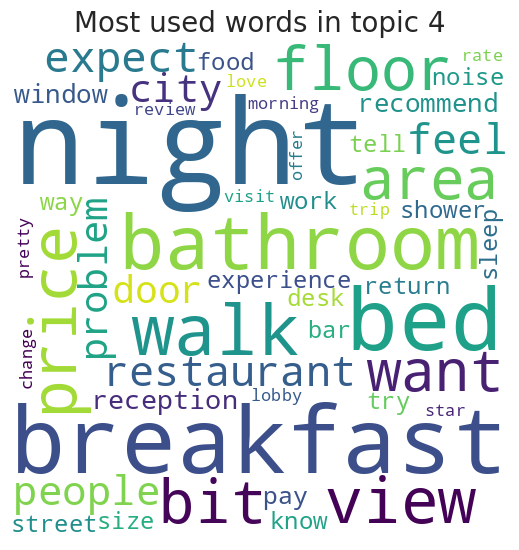

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 4'], title="Most used words in topic 4")

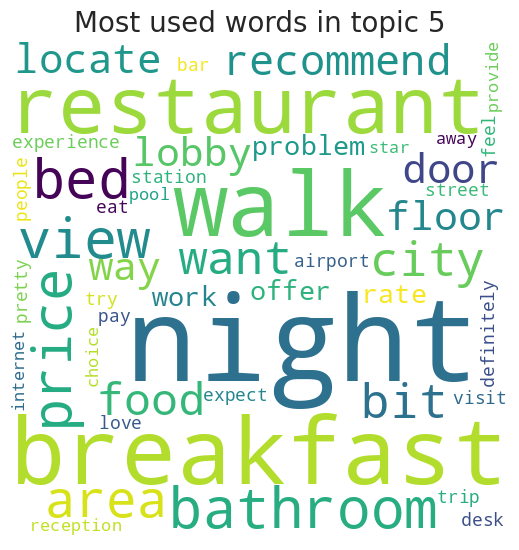

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 5'], title="Most used words in topic 5")

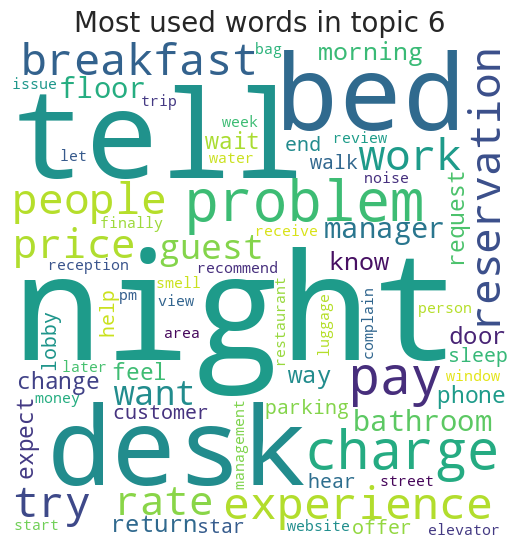

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 6'], title="Most used words in topic 6")

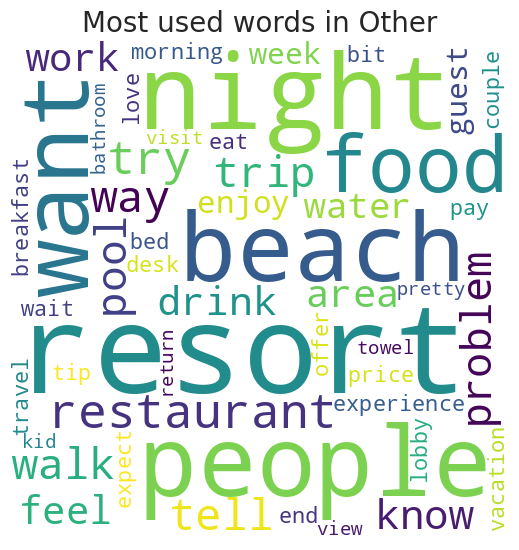

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'Other'], title="Most used words in Other")

# **Creating LDA model**

In [ ]:
id2word = corpora.Dictionary(reviews_lemmatized)
texts = reviews_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
# Use TF-IDF
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
from gensim.models.ldamulticore import LdaMulticore

def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 20, limit = 30, step = 2)

model created
0.5847223145371728
model created
0.6004274949029933
model created
0.5837651839440418
model created
0.5955841955858776
model created
0.6116645500807959


In [ ]:
import matplotlib.pyplot as plt

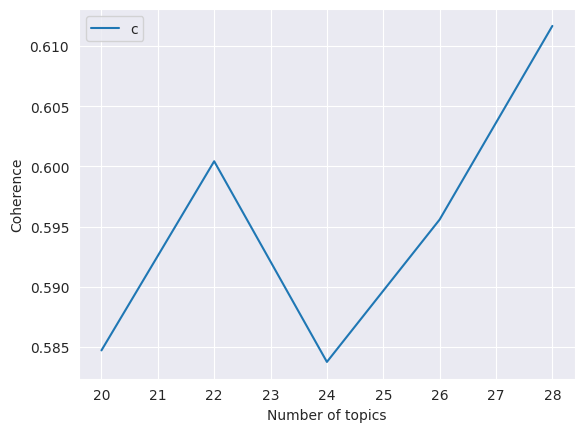

In [ ]:
limit, start, step = 30, 20, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
index = coherence_values.index(max(coherence_values))
model_list[index].show_topics()

[(11,
  '0.005*"peninsula" + 0.003*"helpfull" + 0.003*"accross" + 0.002*"reflection" + 0.002*"dressing_gown" + 0.001*"los_angeles" + 0.001*"future_visit" + 0.001*"half_dozen" + 0.001*"spoke_english" + 0.001*"riverwalk"'),
 (4,
  '0.005*"opera" + 0.004*"mandarin" + 0.003*"cbd" + 0.003*"transit" + 0.003*"nicely_appointe" + 0.002*"tucked_away" + 0.002*"position" + 0.002*"canadian" + 0.002*"major_site" + 0.002*"rented_bike"'),
 (20,
  '0.003*"blvd" + 0.003*"hollywood" + 0.002*"hub" + 0.002*"tight_budget" + 0.001*"instruct" + 0.001*"penalty" + 0.001*"drown" + 0.001*"taste_mouth" + 0.001*"prepay" + 0.001*"exploration"'),
 (22,
  '0.005*"tuscany" + 0.004*"sparkle" + 0.003*"disapointe" + 0.003*"refresh" + 0.003*"euro" + 0.002*"banquet" + 0.002*"straighten" + 0.002*"toaster" + 0.002*"vieque" + 0.002*"adjoin"'),
 (6,
  '0.025*"barcelona" + 0.003*"favourite" + 0.003*"discovery" + 0.003*"backpacker" + 0.003*"daylight" + 0.002*"plunge" + 0.002*"excelent" + 0.002*"disturbance" + 0.002*"bean" + 0.002

In [ ]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.7 MB/s eta 0:00:00


In [ ]:
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(model_list[index], corpus_tfidf, id2word, sort_topics = False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [ ]:
def format_topics_sentences(lda_model, corpus, data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df_topic_sents_keywords = format_topics_sentences(model_list[index], corpus_tfidf, texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Streaming output truncated to the last 5000 lines.
<ipython-input-53-34cd0742feee>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-53-34cd0742feee>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-53-34cd0742feee>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-53-34cd0742feee>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-53-34cd0742feee>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-53-34cd0742feee>:9: FutureWarning:

The frame.append method is deprecated and will b

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0              15              0.5226   
1            1              15              0.5969   
2            2              15              0.5235   
3            3               2              0.6093   
4            4              15              0.6292   
5            5              15              0.4141   
6            6              15              0.4835   
7            7              15              0.4003   
8            8              15              0.3545   
9            9              15              0.4781   

                                            Keywords  \
0  resort, beach, pool, food, restaurant, night, ...   
1  resort, beach, pool, food, restaurant, night, ...   
2  resort, beach, pool, food, restaurant, night, ...   
3  harbour, view, night, walk, bed, city, museum,...   
4  resort, beach, pool, food, restaurant, night, ...   
5  resort, beach, pool, food, restaurant, night, ...   
6  resort, beach, pool, food, restaurant, night, ...   
7  resort, beach, pool, food, restaurant, night, ...   
8  resort, beach, pool, food, restaurant, night, ...   
9  resort, beach, pool, food, restaurant, night, ...   

                                                Text  
0  [parking, deal, anniversary, evening, advice, ...  
1  [charge, diamond_member, decide, chain, shoot,...  
2  [experience, level, positive, bathroom, bed, h...  
3  [stroll, downtown, shopping, area, sign, anima...  
4  [game, downfall, view, building, complain, web...  
5  [weekend, attend, friend, husband, celebrate, ...  
6  [city, husband, spend, night, business, trip, ...  
7  [housekeeping, quality, chock, feel, home, exp...  
8  [generous, decorate, uniquely, remodel, build,...  
9  [reception, bed, particularly, like, reception...

In [ ]:
topic_counts = df_dominant_topic.Dominant_Topic.value_counts().sort_values(ascending=True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ValueError: ignored

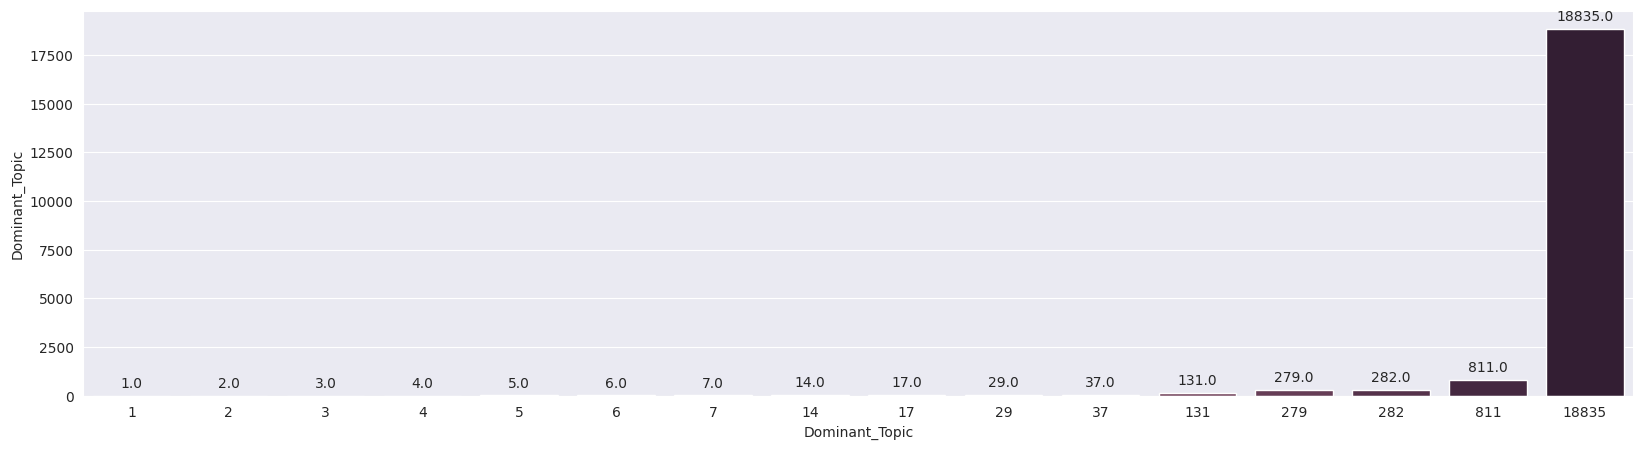

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x=topic_counts.index, y=topic_counts, data=topic_counts,  palette="ch:.25")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax = ax.set_xticklabels(topic_counts.index, rotation = 45, ha="right")

In [ ]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head(10)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic_Num  Topic_Perc_Contrib  \
0          0              0.2262   
1          1              0.4982   
2          2              0.6794   
3          4              0.2888   
4          6              0.4145   
5          7              0.4405   
6          8              0.2494   
7          9              0.6697   
8         10              0.6137   
9         11              0.2654   

                                            Keywords  \
0  recomend, sofitel, helpfull, bin, din, scrambl...   
1  smelly, decoration, euro, lounger, blind, hell...   
2  harbour, view, night, walk, bed, city, museum,...   
3  opera, mandarin, cbd, transit, nicely_appointe...   
4  barcelona, favourite, discovery, backpacker, d...   
5  diamond, exellent, pleasantly, support, festiv...   
6  ceiling_window, itch, children, marriage, silk...   
7  train_station, florence, queue, breakfast, nig...   
8  hong_kong, stopover, organise, terrace, taxi_d...   
9  peninsula, helpfull, accross, reflection, dres...   

                                                Text  
0              [beach, punta_cana, food, cockroache]  
1  [decoration, bed, sheet, shower, breakfast, re...  
2  [update, building, heart, night, year, heart, ...  
3  [transit, trip, attentive, transit, stop, hong...  
4          [four_star, barcelona, area, area, offer]  
5  [night, people, vacate, bother, guest, hesitat...  
6                             [view, weekend, brill]  
7  [resort, spend, honeymoon, resort, condition, ...  
8  [home, home, haven, tranquility, set, option, ...  
9       [allway, excellend, option, price, helpfull]

# **LSA**

In [ ]:
pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
reviews = pd.read_csv('/content/drive/MyDrive/tripadvisor_hotel_reviews.csv',  encoding= 'utf-8')
reviews.head()

Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

In [ ]:
reviewed_data = reviews['Review']
reviewed_data.head()

0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
2    nice rooms not 4* experience hotel monaco seat...
3    unique, great stay, wonderful time hotel monac...
4    great stay great stay, went seahawk game aweso...
Name: Review, dtype: object

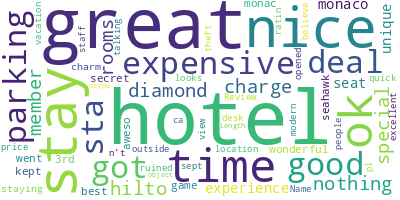

In [ ]:
#Import the wordcloud library
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='grey')
# Generate a word cloud
wordcloud.generate(str(reviews['Review']))
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_reviews = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_reviews, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_reviews.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

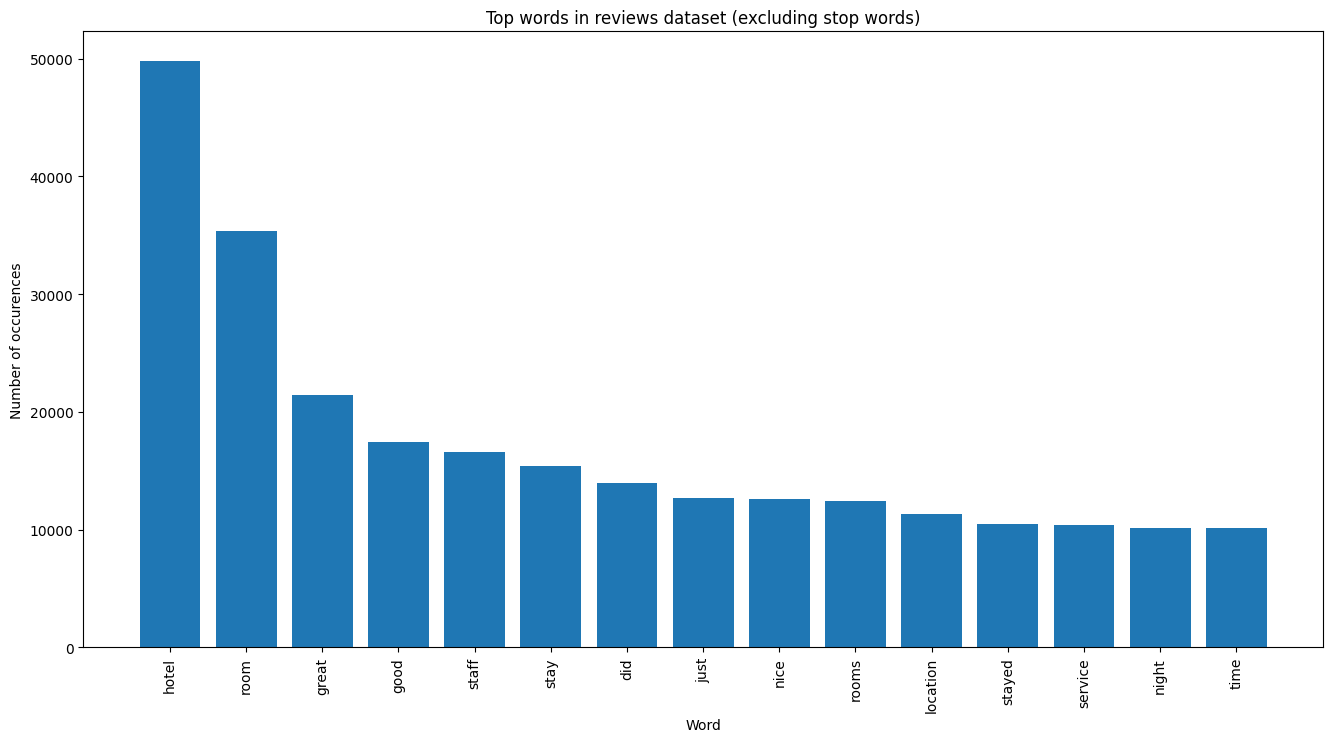

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reviewed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in reviews dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [ ]:
tagged_reviews = [TextBlob(reviewed_data[i]).pos_tags for i in range(reviewed_data.shape[0])]

In [ ]:
tagged_reviews_df = pd.DataFrame({'tags':tagged_reviews})

word_counts = [] 
pos_counts = {}

for review in tagged_reviews_df[u'tags']:
    word_counts.append(len(review))
    for tag in review:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per reviews: ', np.mean(word_counts))

Total number of words:  2142557
Mean number of words per reviews:  104.56088038651116


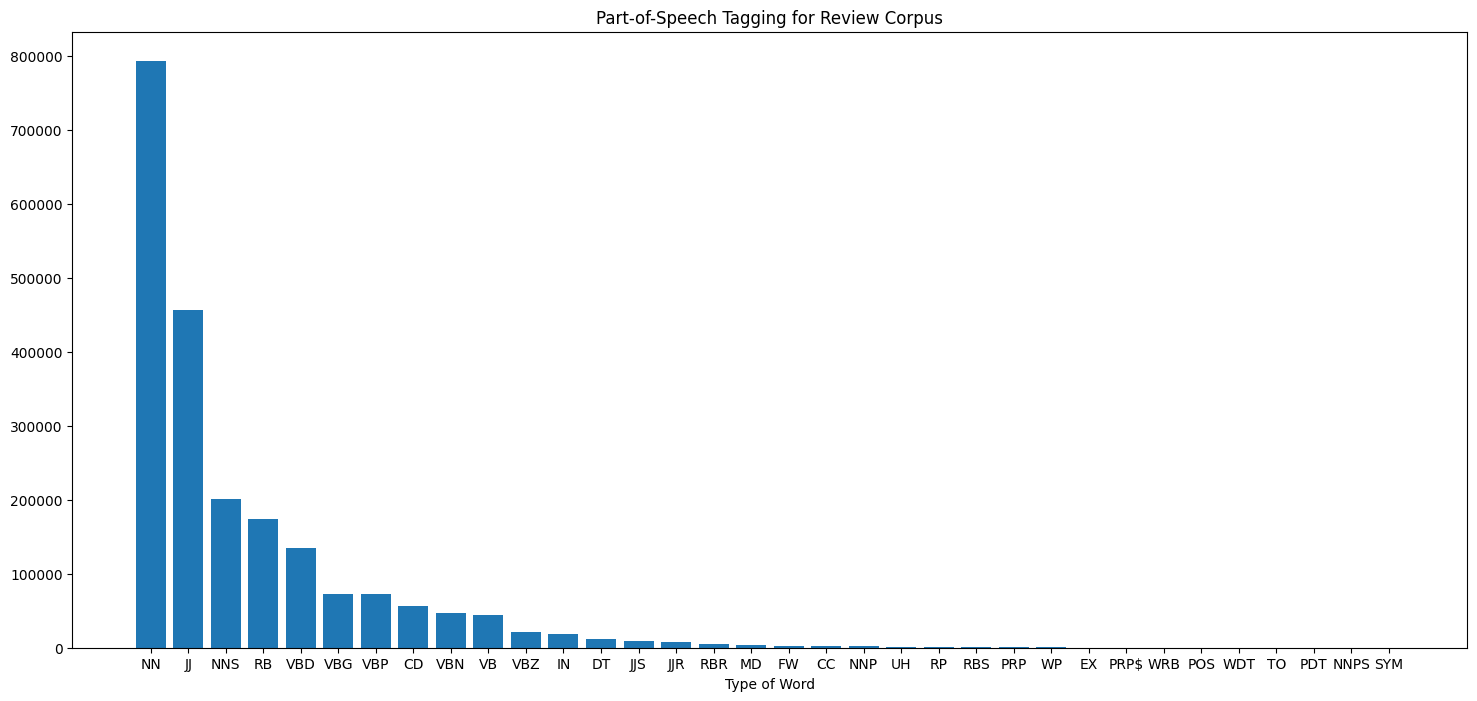

In [ ]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Review Corpus');
ax.set_xlabel('Type of Word');

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reviewed_data.sample(n=1000, random_state=0).values

print('Review before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Review after vectorization: \n{}'.format(small_document_term_matrix[123]))

Review before vectorization: great hotel, brutal tour stayed hotel catedral 1 week late november, staff friendly helpful, rooftop patio nice place wind end day litre bottles sol 7 11 corner 16 pesos liter, bar hotel noisy thursday saturday not expecting peace quiet center mexico city wasnt big deal, beds really hard day walking fell asleep easily, hotel met exceeded expectations prime location price right.the tour hand nightmare, taken tour roldan travel 2 years ago previous trip city, great informative interesting, high expectations, friends travel told great pyramids fun, wrong, met guide cathedral guadalupe joining tour progress, waited 15 minutes inconsiderate lady interested shopping going pyramids, different story wont fresh lol, way pyramids stopped obsidian art factory, tour facility rushed store chance spend thousands dollars masks figurines, no thanks, pyramids, tourist trap arrived finally pyramids, truly appreciate need spend 3 hours, 45 minutes inconsiderate shopper strike

In [ ]:
n_topics = 4

In [ ]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [ ]:
#Topics for document 0:
for i, topic in enumerate(lsa_topic_matrix[0]):
    print("Topic ", i, " : ", topic*100)

Topic  0  :  599.0442936913364
Topic  1  :  -101.29784975558498
Topic  2  :  -35.92234845476861
Topic  3  :  -80.95763662174922


In [ ]:
print(lsa_model.components_.shape) # (no_of_topics*no_of_words)
print(lsa_model.components_)

(4, 11519)
[[ 1.05771500e-02  5.55408544e-04  3.43730416e-04 ...  1.84447093e-05
   8.46388696e-04  1.31448435e-04]
 [ 5.25891300e-03  3.92233036e-04  2.59782054e-05 ... -4.95553088e-05
   3.05023246e-03 -1.41801888e-04]
 [ 9.52676623e-03 -3.07641722e-04 -5.10319480e-04 ... -1.11917712e-04
  -2.01769843e-03 -1.16950927e-04]
 [ 6.40501161e-03 -2.01940429e-03 -6.15677925e-04 ...  1.13928613e-04
   1.22392938e-02 -3.82259083e-04]]


In [ ]:
#Now we can get a list of the important words for each of the 5 topics as shown. 
#For simplicity here I have shown 5 words for each topic.
vocab = small_count_vectorizer.get_feature_names_out()
topic_content = []
for v in lsa_model.components_:
    sorted_vocab = sorted(zip(vocab, v), key=lambda x : x[1], reverse=True)
    topic_content.append({x:y for x, y in sorted_vocab})

In [ ]:
print("Top 5 words in topic 1 : ", list(topic_content[0].keys())[:5])
print("Top 5 words in topic 2 : ", list(topic_content[1].keys())[:5])
print("Top 5 words in topic 3 : ", list(topic_content[2].keys())[:5])
print("Top 5 words in topic 4 : ", list(topic_content[3].keys())[:5])

Top 5 words in topic 1 :  ['hotel', 'room', 'did', 'beach', 'great']
Top 5 words in topic 2 :  ['beach', 'resort', 'food', 'did', 'pool']
Top 5 words in topic 3 :  ['room', 'desk', 'asked', 'told', 'night']
Top 5 words in topic 4 :  ['food', 'hotel', 'restaurant', 'dominican', 'don__ç_é_']


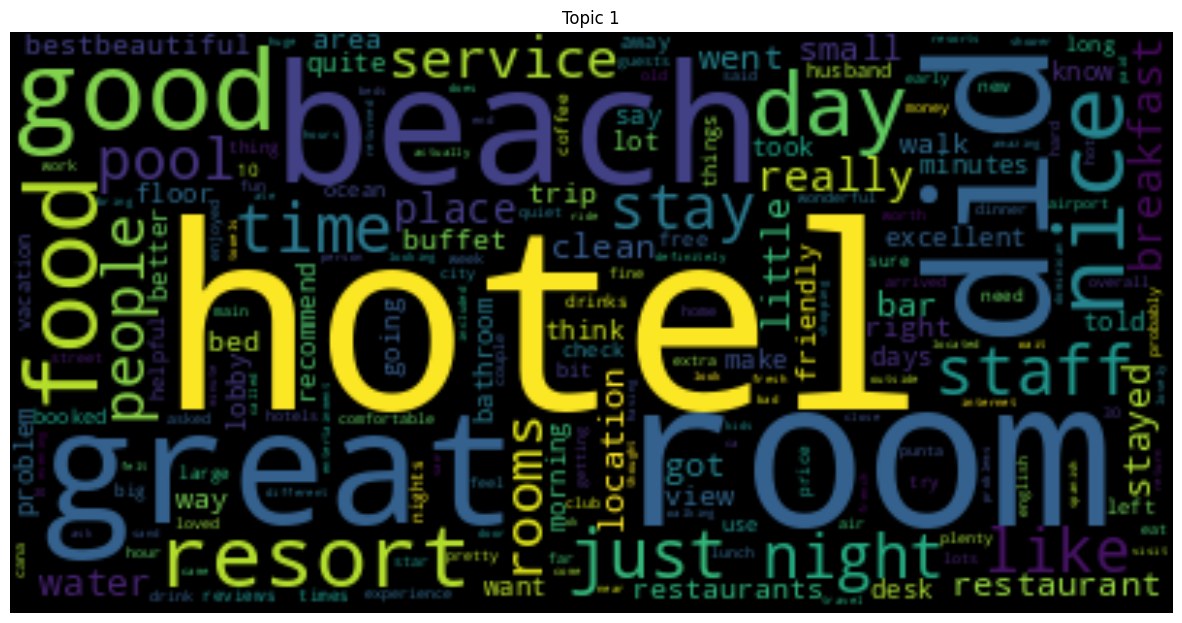

In [ ]:
wc1= WordCloud(background_color="black", max_words=500)
wc1.generate_from_frequencies(topic_content[0])

fig = plt.figure(1, figsize=(15, 15))
plt.imshow(wc1, interpolation="bilinear")
plt.title("Topic 1")
plt.axis("off")
plt.show()

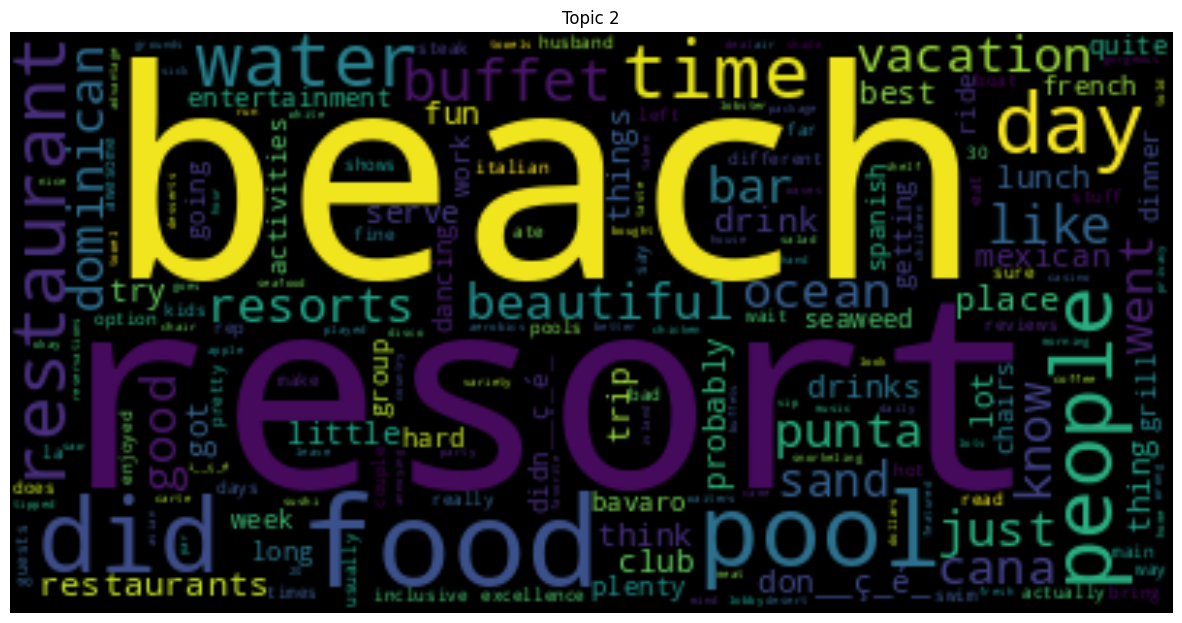

In [ ]:
wc2= WordCloud(background_color="black", max_words=500)
wc2.generate_from_frequencies(topic_content[1])

fig = plt.figure(1, figsize=(15, 15))
plt.imshow(wc2, interpolation="bilinear")
plt.title("Topic 2")
plt.axis("off")
plt.show()

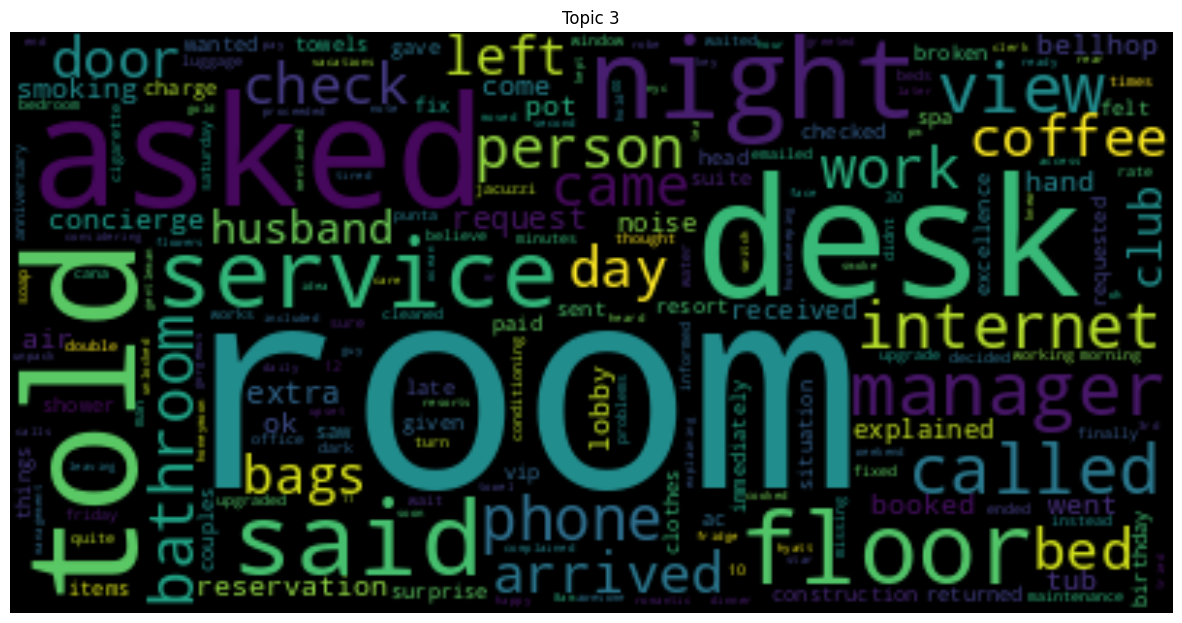

In [ ]:
wc3= WordCloud(background_color="black", max_words=500)
wc3.generate_from_frequencies(topic_content[2])

fig = plt.figure(1, figsize=(15, 15))
plt.imshow(wc3, interpolation="bilinear")
plt.title("Topic 3")
plt.axis("off")
plt.show()

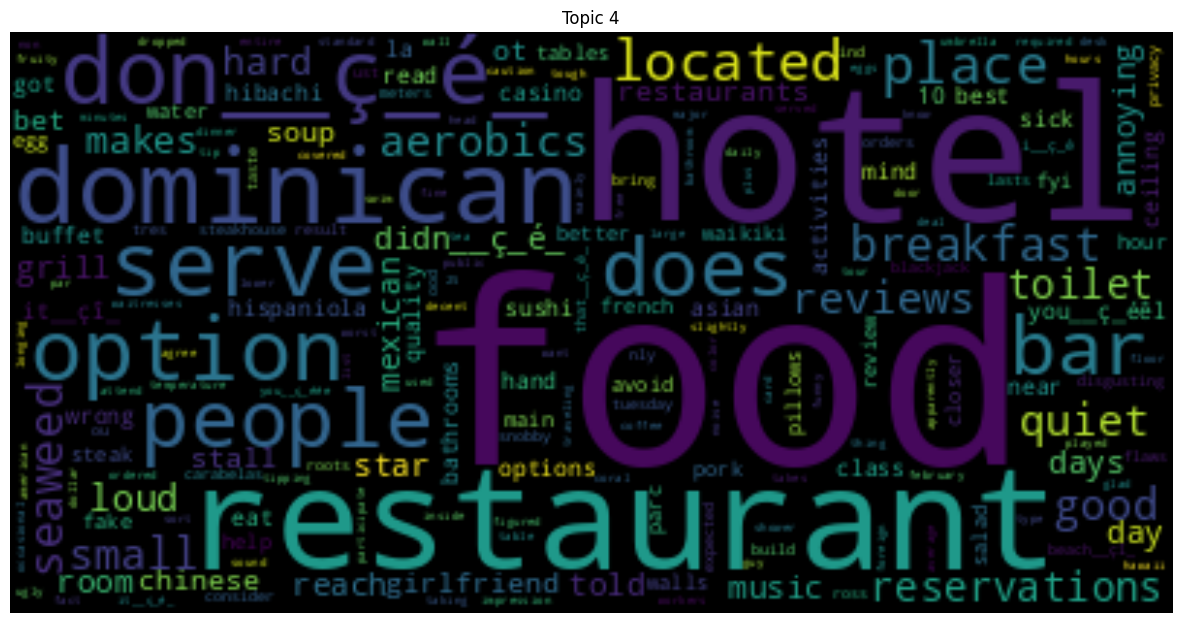

In [ ]:
wc4= WordCloud(background_color="black", max_words=500)
wc4.generate_from_frequencies(topic_content[3])

fig = plt.figure(1, figsize=(15, 15))
plt.imshow(wc4, interpolation="bilinear")
plt.title("Topic 4")
plt.axis("off")
plt.show()

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [ ]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.750393
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.076584
[t-SNE] KL divergence after 2000 iterations: 0.733722


In [ ]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
# Plotting the Topic Clusters for LSA using Bokeh
output_notebook()
mycolor = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
n_topics=4
plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=500, plot_height=500)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=mycolor[lsa_keys])
    
show(plot)